In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cuda
--- Generating Realistic Synthetic Data (L_max = 3) ---
Generated 22119 data points after creating gaps.
--- Initializing Fourier Feature PINN Model (L_max = 3) ---

--- Starting Optimization Loop ---
Epoch [200/6000], Loss: 236.13770, MSE: 0.04893, TempReg: 236.08876
Epoch [400/6000], Loss: 114.21667, MSE: 0.00275, TempReg: 114.21392
Epoch [600/6000], Loss: 74.99432, MSE: 0.00111, TempReg: 74.99321
Epoch [800/6000], Loss: 44.83736, MSE: 0.00069, TempReg: 44.83667
Epoch [1000/6000], Loss: 24.43135, MSE: 0.00046, TempReg: 24.43089
Epoch [1200/6000], Loss: 24.05124, MSE: 0.00031, TempReg: 24.05093
Epoch [1400/6000], Loss: 20.81002, MSE: 0.00020, TempReg: 20.80982
Epoch [1600/6000], Loss: 12.77324, MSE: 0.00013, TempReg: 12.77312
Epoch [1800/6000], Loss: 17.01427, MSE: 0.00008, TempReg: 17.01418
Epoch [2000/6000], Loss: 12.71068, MSE: 0.00006, TempReg: 12.71062
Epoch [2200/6000], Loss: 10.52541, MSE: 0.00005, TempReg: 10.52536
Epoch [2400/6000], Loss: 12.63137, MSE: 0.0

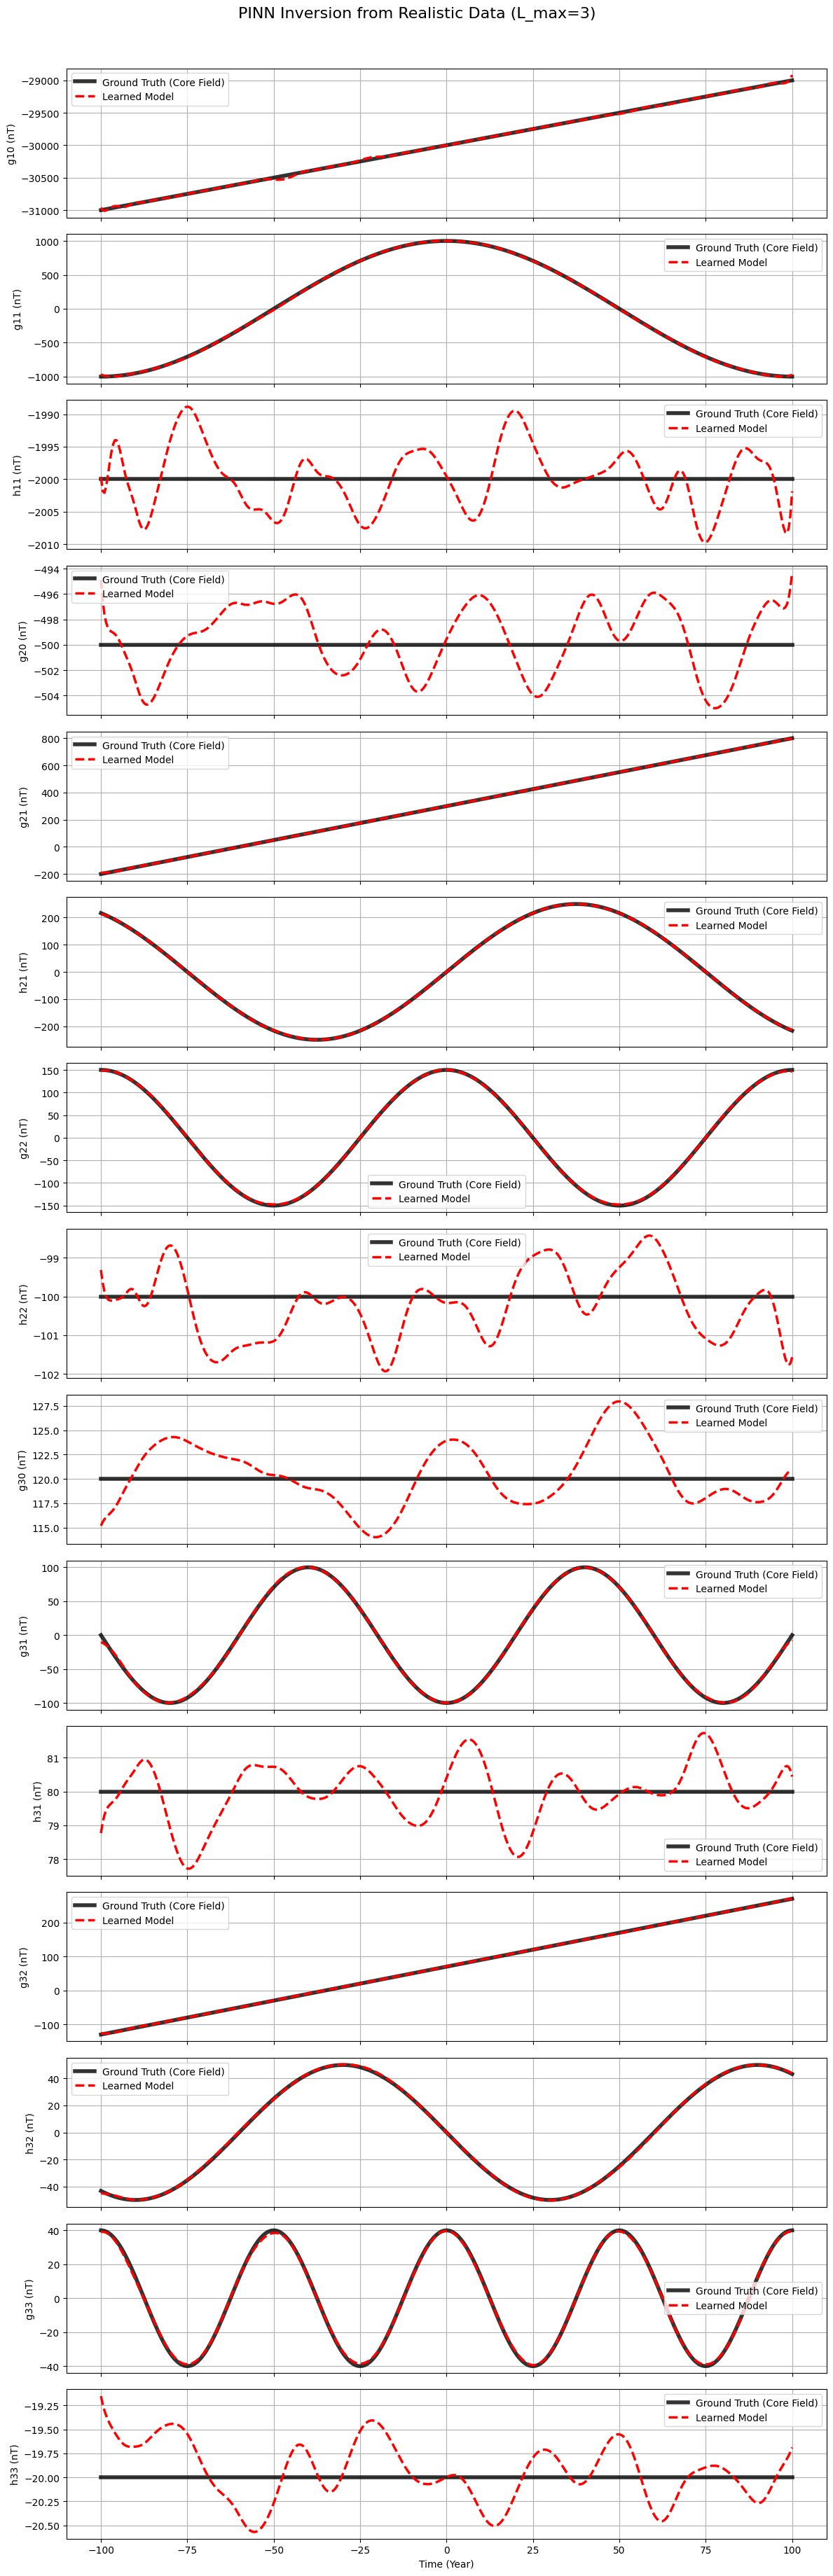

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline

# =============================================================================
# SECTIONS 1A, 1B, 2 (Data Generation and Physics) are UNCHANGED from the
# previous "realistic data" example. I will collapse them for brevity.
# =============================================================================

# (Imagine the code from the previous response for true_model_at_time,
# simulate_satellite_orbit, external_field_coeffs,
# generate_realistic_synthetic_data, and calculate_frechet_matrix is here)

def true_model_at_time(t: torch.Tensor, maxdegree: int) -> torch.Tensor:
    g10 = -30000.0 + 10.0 * t; g11 = 1000.0 * torch.cos(2 * torch.pi * t / 200.0); h11 = -2000.0 * torch.ones_like(t)
    coeffs = [g10, g11, h11]
    if maxdegree >= 2:
        g20 = -500.0 * torch.ones_like(t); g21 = 300.0 + 5.0 * t; h21 = 250.0 * torch.sin(2 * torch.pi * t / 150.0)
        g22 = 150.0 * torch.cos(2 * torch.pi * t / 100.0); h22 = -100.0 * torch.ones_like(t)
        coeffs.extend([g20, g21, h21, g22, h22])
    if maxdegree >= 3:
        g30 = 120.0 * torch.ones_like(t); g31 = -100.0 * torch.cos(2 * torch.pi * t / 80.0); h31 = 80.0 * torch.ones_like(t)
        g32 = 70.0 + 2.0 * t; h32 = -50.0 * torch.sin(2 * torch.pi * t / 120.0); g33 = 40.0 * torch.cos(2 * torch.pi * t / 50.0)
        h33 = -20.0 * torch.ones_like(t); coeffs.extend([g30, g31, h31, g32, h32, g33, h33])
    current_coeffs = len(coeffs); target_coeffs = (maxdegree + 1)**2 - 1
    for _ in range(target_coeffs - current_coeffs): coeffs.append(torch.zeros_like(t))
    return torch.stack(coeffs, dim=-1)

def simulate_satellite_orbit(n_points, t_start=-100, t_end=100, device='cpu'):
    times = torch.linspace(t_start, t_end, n_points, device=device); inclination = torch.deg2rad(torch.tensor(86.0))
    period = 0.0118; precession_period = 180; orbital_phase = 2 * torch.pi * times / period
    asc_node_lon = torch.deg2rad(360.0 * times / precession_period)
    lats_rad = torch.asin(torch.sin(inclination) * torch.sin(orbital_phase))
    lons_rad = asc_node_lon + torch.atan2(torch.cos(inclination) * torch.sin(orbital_phase), torch.cos(orbital_phase))
    lats_deg = torch.rad2deg(lats_rad); lons_deg = torch.rad2deg(lons_rad) % 360.0
    return times, lats_deg, lons_deg

def external_field_coeffs(t: torch.Tensor, device='cpu') -> torch.Tensor:
    g10_ext = 20.0 * torch.sin(2 * torch.pi * t / 7.0) + 10.0 * torch.cos(2 * torch.pi * t)
    coeffs = torch.zeros(t.shape[0], (3 + 1)**2 - 1, device=device); coeffs[:, 0] = g10_ext
    return coeffs

def generate_realistic_synthetic_data(n_points, maxdegree, device):
    print(f"--- Generating Realistic Synthetic Data (L_max = {maxdegree}) ---")
    t_full, lat_full, lon_full = simulate_satellite_orbit(n_points, device=device); true_core_coeffs = true_model_at_time(t_full, maxdegree)
    frechet_matrices = calculate_frechet_matrix(lat_full, lon_full, maxdegree); true_core_xyz = torch.bmm(frechet_matrices, true_core_coeffs.unsqueeze(-1)).squeeze(-1)
    ext_coeffs = external_field_coeffs(t_full, device=device); external_xyz = torch.bmm(frechet_matrices, ext_coeffs.unsqueeze(-1)).squeeze(-1)
    base_noise = 2.0; polar_noise_factor = 10.0; noise_amplitude = base_noise + polar_noise_factor * torch.sin(torch.deg2rad(torch.abs(lat_full)))**2
    noise = torch.randn_like(true_core_xyz) * noise_amplitude.unsqueeze(-1); observed_xyz = true_core_xyz + external_xyz + noise
    n_gaps = 5; gap_size = n_points // 40; mask = torch.ones(n_points, dtype=torch.bool, device=device)
    for _ in range(n_gaps):
        start_index = torch.randint(0, n_points - gap_size, (1,)).item(); mask[start_index : start_index + gap_size] = False
    t_obs, lat_obs, lon_obs = t_full[mask], lat_full[mask], lon_full[mask]; d_obs = observed_xyz[mask]
    print(f"Generated {len(t_obs)} data points after creating gaps.")
    return t_obs, lat_obs, lon_obs, d_obs, t_full, true_core_coeffs

def calculate_frechet_matrix(lat, lon, n_max):
    lat = torch.deg2rad(lat); lon = torch.deg2rad(lon); theta = np.pi/2 - lat; num_coeffs = n_max * (n_max + 2)
    G = torch.zeros((len(theta), 3, num_coeffs), device=theta.device); cos_theta = torch.cos(theta); sin_theta = torch.sin(theta)
    sin_theta[sin_theta == 0] = 1e-8; P = torch.zeros((n_max + 1, n_max + 1, len(theta)), device=theta.device)
    dP = torch.zeros((n_max + 1, n_max + 1, len(theta)), device=theta.device); P[0, 0, :] = 1.; P[1, 1, :] = sin_theta
    root_n_n_1 = torch.from_numpy(np.sqrt(np.arange(4, 2*n_max + 1, 2))).to(theta.device)
    for n in range(2, n_max + 1): P[n, n, :] = root_n_n_1[n-2] * P[n-1, n-1, :] * sin_theta
    P[1, 0, :] = cos_theta
    for n in range(2, n_max + 1): P[n, n-1, :] = np.sqrt(2*n-1) * P[n, n, :] * cos_theta / sin_theta
    for n in range(2, n_max + 1):
        for m in range(n - 1): P[n, m, :] = ((2*n-1)*P[n-1, m, :]*cos_theta - np.sqrt((n-1)**2-m**2)*P[n-2, m, :]) / np.sqrt(n**2-m**2)
    dP[0, 0, :] = 0.
    for n in range(1, n_max+1):
        for m in range(n+1):
            if n==m: dP[n, n, :] = np.sqrt(n/2)*P[n, n-1, :] + n*cos_theta/sin_theta * P[n, n, :]
            else: dP[n, m, :] = (np.sqrt(n**2-m**2)*P[n-1, m, :] - n*cos_theta*P[n, m, :]) / sin_theta
    k = 0
    for n in range(1, n_max + 1):
        for m in range(n + 1):
            if m == 0: G[:, 0, k], G[:, 2, k] = dP[n, m, :], -n * P[n, m, :]; k += 1
            else:
                cos_m_lon, sin_m_lon = torch.cos(m * lon), torch.sin(m * lon)
                G[:, 0, k] = dP[n, m, :]*cos_m_lon; G[:, 1, k] = m*P[n, m, :]/sin_theta*sin_m_lon; G[:, 2, k] = -n*P[n, m, :]*cos_m_lon; k += 1
                G[:, 0, k] = dP[n, m, :]*sin_m_lon; G[:, 1, k] = -m*P[n, m, :]/sin_theta*cos_m_lon; G[:, 2, k] = -n*P[n, m, :]*sin_m_lon; k += 1
    G[:, 0, :] *= -1; G[:, 2, :] *= -1
    return G
# =============================================================================
# 3. NEW: THE FOURIER FEATURE PINN MODEL CLASS
# =============================================================================

class PINNInversion(nn.Module):
    def __init__(self, t_min, t_max, maxdegree, mapping_size=256, scale=10.0, hidden_dim=256, n_layers=4, device='cpu'):
        super().__init__()
        print(f"--- Initializing Fourier Feature PINN Model (L_max = {maxdegree}) ---")
        
        self.maxdegree = maxdegree
        self.nr_coeffs = (maxdegree + 1)**2 - 1
        self.t_min = t_min
        self.t_max = t_max
        
        # --- 1. Fourier Feature Mapping ---
        # The mapping matrix B is fixed, not learned.
        self.B = torch.randn((1, mapping_size), device=device) * scale
        # We register it as a buffer so it's moved to the correct device with .to(device)
        self.register_buffer('B_matrix_ff', self.B)
        
        # --- 2. Multi-Layer Perceptron (MLP) ---
        input_dim = mapping_size * 2 # (sin, cos) for each frequency
        
        layers = [nn.Linear(input_dim, hidden_dim), nn.GELU()]
        for _ in range(n_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.GELU()])
        layers.append(nn.Linear(hidden_dim, self.nr_coeffs))
        
        self.mlp = nn.Sequential(*layers)
        
        # --- 3. Coefficient Scaling (still very important!) ---
        scaling = []
        if maxdegree >= 1: scaling.extend([30000.0, 2000.0, 2000.0])
        if maxdegree >= 2: scaling.extend([600.0, 400.0, 400.0, 200.0, 200.0])
        if maxdegree >= 3: scaling.extend([150.0, 120.0, 120.0, 80.0, 80.0, 50.0, 50.0])
        self.coeff_scaling = torch.tensor(scaling, device=device)

    def _normalize_time(self, t):
        # Normalizing input to [-1, 1] is good practice for NNs
        return 2 * (t - self.t_min) / (self.t_max - self.t_min) - 1

    def fourier_mapping(self, t_normalized):
        # Project normalized time onto the random Fourier directions
        t_proj = (t_normalized.unsqueeze(-1) @ self.B_matrix_ff)
        # Concatenate sine and cosine features
        return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)

    def get_coeffs_at_times(self, times: torch.Tensor) -> torch.Tensor:
        # The core logic: map time -> fourier features -> MLP -> scaled coeffs -> physical coeffs
        t_norm = self._normalize_time(times)
        features = self.fourier_mapping(t_norm)
        scaled_coeffs = self.mlp(features)
        physical_coeffs = scaled_coeffs * self.coeff_scaling
        return physical_coeffs

    def forward(self, t: torch.Tensor, lat: torch.Tensor, lon: torch.Tensor) -> torch.Tensor:
        coeffs_at_t = self.get_coeffs_at_times(t)
        frechet_matrices = calculate_frechet_matrix(lat, lon, self.maxdegree)
        predicted_xyz = torch.bmm(frechet_matrices, coeffs_at_t.unsqueeze(-1)).squeeze(-1)
        return predicted_xyz
        
# =============================================================================
# 4. TRAINING (OPTIMIZATION) LOOP
# =============================================================================

# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
MAX_DEGREE = 3
N_SAMPLES = 25000

# --- Hyperparameters ---
LEARNING_RATE = 1e-4      # NNs often benefit from smaller learning rates
NUM_EPOCHS = 6000         
WEIGHT_DECAY = 1e-6       # L2 regularization on network weights
TEMP_LAMBDA = 5e-3        # Temporal regularization strength

# --- Prepare Data ---
t_obs, lat_obs, lon_obs, d_obs, t_gt, gt_coeffs = generate_realistic_synthetic_data(
    N_SAMPLES, MAX_DEGREE, DEVICE
)

# --- Normalize the Data ---
data_mean = d_obs.mean(dim=0, keepdim=True)
data_std = d_obs.std(dim=0, keepdim=True)
d_obs_normalized = (d_obs - data_mean) / data_std

# --- Initialize Model and Optimizer ---
model = PINNInversion(
    t_min=-100, t_max=100, maxdegree=MAX_DEGREE, device=DEVICE
).to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()

print("\n--- Starting Optimization Loop ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    
    # Forward pass to get data misfit
    d_pred = model(t_obs, lat_obs, lon_obs)
    d_pred_normalized = (d_pred - data_mean) / data_std
    loss_mse = loss_fn(d_pred_normalized, d_obs_normalized)
    
    # --- NEW Temporal Regularization for PINNs ---
    # We enforce smoothness by penalizing the model's time derivative.
    # We sample random times, calculate the output, and then use autograd
    # to find the derivative of the output w.r.t the input time.
    rand_times = torch.rand(512, device=DEVICE) * 200 - 100
    rand_times.requires_grad_(True)
    
    coeffs_at_rand_t = model.get_coeffs_at_times(rand_times)
    
    # Sum over coefficients so we can take a single gradient
    summed_coeffs = coeffs_at_rand_t.sum() 
    
    # Use autograd to get the first derivative w.r.t time
    # This computes d(coeffs)/dt for each coefficient at each random time
    grad_outputs = torch.ones_like(summed_coeffs)
    gradients = torch.autograd.grad(summed_coeffs, rand_times, grad_outputs=grad_outputs)[0]
    
    # Penalize the L2 norm of the time derivative (encourages smoothness)
    loss_temporal = TEMP_LAMBDA * torch.mean(gradients**2)
    
    total_loss = loss_mse + loss_temporal
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {total_loss.item():.5f}, "
              f"MSE: {loss_mse.item():.5f}, TempReg: {loss_temporal.item():.5f}")

# =============================================================================
# 5. PLOTTING AND EVALUATION (Unchanged)
# =============================================================================
print("\n--- Plotting Final Results ---")
model.eval()
plot_times = torch.linspace(-100, 100, 400, device=DEVICE)
with torch.no_grad():
    learned_coeffs = model.get_coeffs_at_times(plot_times)

ground_truth_coeffs = true_model_at_time(plot_times, MAX_DEGREE)
learned_coeffs_np = learned_coeffs.cpu().numpy()
ground_truth_coeffs_np = ground_truth_coeffs.cpu().numpy()
plot_times_np = plot_times.cpu().numpy()

labels = []
for l in range(1, MAX_DEGREE + 1):
    labels.append(f'g{l}0'); 
    for m in range(1, l + 1): labels.extend([f'g{l}{m}', f'h{l}{m}'])

fig, axes = plt.subplots(model.nr_coeffs, 1, figsize=(12, 2.5 * model.nr_coeffs), sharex=True)
fig.suptitle(f"PINN Inversion from Realistic Data (L_max={MAX_DEGREE})", fontsize=16)
for i in range(model.nr_coeffs):
    ax = axes[i] if model.nr_coeffs > 1 else axes
    ax.plot(plot_times_np, ground_truth_coeffs_np[:, i], 'k-', label='Ground Truth (Core Field)', linewidth=4, alpha=0.8)
    ax.plot(plot_times_np, learned_coeffs_np[:, i], 'r--', label='Learned Model', linewidth=2.5)
    ax.set_ylabel(f'{labels[i]} (nT)'); ax.legend(); ax.grid(True)
axes[-1].set_xlabel('Time (Year)'); plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()